In [ ]:
import tensorflow as tf


# Check tensorflow version
print("Using Tensorflow %s\n" % (tf.__version__))

Using Tensorflow 2.7.0



In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

from sklearn import metrics
import math
import numpy as np
from tensorflow.keras.models import Model

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

pixels = 500
# Input pixel dimensions.  All training and test examples will be resized to (pixel, pixel, 3)
conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(pixels,pixels,3))

conv_base.trainable = False

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10, zoom_range= [0.9,1.1])
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
conv_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 249, 249, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 249, 249, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                               

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Conv2D(1024, (3, 3), padding="same", strides=(1, 1), activation="relu", name="ClassConv"))
model.add(layers.GlobalAveragePooling2D(name="GAP"))
model.add(layers.Dense(2048, activation='relu',name='fc-1'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu',name='fc-2'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(40, activation="softmax", name="class"))

In [ ]:
all_amp_layer_weights = model.layers[-1].get_weights()[0]

In [ ]:
all_amp_layer_weights.shape

(1024, 40)

In [ ]:
cam_shape = tuple(model.get_layer("ClassConv").output.get_shape().as_list()[1:])
cam_shape

(14, 14, 1024)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10, zoom_range= [0.9,1.1])
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
BATCH_SIZE = 128


train_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/standford40_tvt_ds_seed_13/train", batch_size=BATCH_SIZE, target_size=(pixels,pixels), class_mode = 'categorical')
valid_generator = valid_datagen.flow_from_directory("/content/drive/MyDrive/standford40_tvt_ds_seed_13/validation", batch_size=BATCH_SIZE, target_size=(pixels,pixels), class_mode = 'categorical', shuffle=False)
test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/standford40_tvt_ds_seed_13/test", batch_size=BATCH_SIZE, target_size=(pixels,pixels), class_mode = 'categorical', shuffle=False)

y_true = test_generator.classes

train_m = len(train_generator.classes)
test_m = len(test_generator.classes)
valid_m = len(valid_generator.classes)


mapping = dict()
for activity, idx in train_generator.class_indices.items():
    mapping[idx] = activity

train_steps = math.ceil(train_m/BATCH_SIZE)
test_steps = math.ceil(test_m/BATCH_SIZE)
valid_steps = math.ceil(valid_m/BATCH_SIZE)

Found 6665 images belonging to 40 classes.
Found 1417 images belonging to 40 classes.
Found 1450 images belonging to 40 classes.


In [ ]:
print(train_steps)

53


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


filepath = "models/class_only/checkpoints/epoch_{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')

callback = tf.keras.callbacks.EarlyStopping(monitor='classification_loss', patience=5)

logdir = "models/class_only/logs"

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4), metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
prev_epochs = 0
epochs = 25

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=train_steps, initial_epoch=prev_epochs, epochs=epochs, validation_data=valid_generator, validation_steps=valid_steps, callbacks=[tensorboard_callback, checkpoint])

#history = model.fit_generator(train_generator, steps_per_epoch=train_steps, initial_epoch=prev_epochs, epochs=epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/25
53/53 [==============================] - ETA: 0s - loss: 2.8767 - acc: 0.2929 
Epoch 00001: val_loss improved from inf to 1.40153, saving model to models/class_only/checkpoints/epoch_01-1.40.h5
53/53 [==============================] - 2823s 53s/step - loss: 2.8767 - acc: 0.2929 - val_loss: 1.4015 - val_acc: 0.7043
Epoch 2/25
53/53 [==============================] - ETA: 0s - loss: 1.3955 - acc: 0.6207
Epoch 00002: val_loss improved from 1.40153 to 0.79734, saving model to models/class_only/checkpoints/epoch_02-0.80.h5
53/53 [==============================] - 470s 9s/step - loss: 1.3955 - acc: 0.6207 - val_loss: 0.7973 - val_acc: 0.7812
Epoch 3/25
53/53 [==============================] - ETA: 0s - loss: 0.9714 - acc: 0.7169
Epoch 00003: val_loss improved from 0.79734 to 0.67261, saving model to models/class_only/checkpoints/epoch_03-0.67.h5
53/53 [==============================] - 467s 9s/step - loss: 0.9714 - acc: 0.7169 - val_loss: 0.6726 - val_acc: 0.8038
Epoch 4/25
53/53 

In [ ]:
model.save('standford40_tvt_ds_seed_13_inceptionResnet_ann_added_02.h5')

In [ ]:
import shutil
shutil.copy('/content/standford40_tvt_ds_seed_13_inceptionResnet_ann_added_02.h5','/content/drive/MyDrive/')

'/content/drive/MyDrive/standford40_tvt_ds_seed_13_inceptionResnet_ann_added_02.h5'

In [ ]:
 score = model.evaluate_generator(test_generator, test_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
score

[0.519550085067749, 0.8600000143051147]

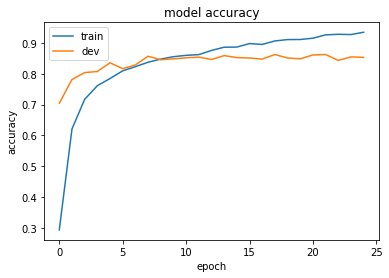

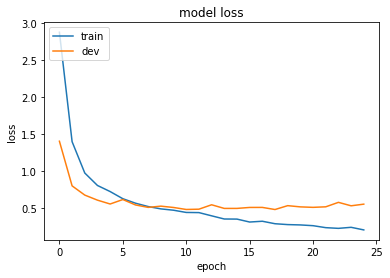

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [42]:
predictions = model.predict_generator(test_generator, test_steps)
predictions = predictions.argmax(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [43]:
(y_true == predictions).mean()

0.86

In [44]:
test_labels = test_generator.classes;
test_generator.class_indices;

0.86
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        47
           1       0.97      0.97      0.97        37
           2       0.85      0.81      0.83        36
           3       0.96      0.96      0.96        28
           4       0.98      0.98      0.98        46
           5       0.78      0.78      0.78        37
           6       0.92      1.00      0.96        33
           7       0.81      0.72      0.76        29
           8       0.83      0.60      0.70        40
           9       0.91      0.87      0.89        23
          10       0.88      0.98      0.93        47
          11       0.93      0.98      0.95        43
          12       0.95      0.97      0.96        38
          13       1.00      0.95      0.97        38
          14       0.98      1.00      0.99        43
          15       0.90      0.77      0.83        48
          16       0.82      0.90      0.86        31
          17       0.9

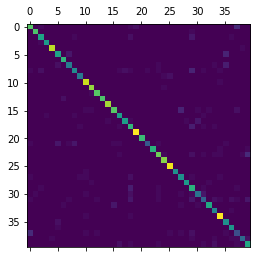

In [45]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(accuracy_score(test_labels,predictions));
print(classification_report(test_labels,predictions));
cm_train = confusion_matrix(test_labels,predictions);
plt.matshow(cm_train);